## Hands-On Labs 1
## Objectives
In this hands-on, you will fine-tune your own LLM to enable the LLM to write Tang poems

**TODOs**
1. Read the slides and make sure you know the objectives of this homework.
2. Save a copy of this Colab notebook.
3. Follow the steps in this Colab notebook to fine-tune your LLM.

**Tips**: At the top of each cell, it shows whether you need to change hyperparameters in that cell and how long it might take.

## Activate GPU
Since you will fine-tune a model, you **MUST** activate GPU so that this homework can be done in reasonable time (1~2 hrs)

### **MUST READ**:

Colab does **NOT** guarantee the GPU access for free user ([ref](https://research.google.com/colaboratory/faq.html#idle-timeouts)). It is possible you get an message saying "Cannot connect to GPU backend" which means there are no enough GPU resources for you now. When this happens, you may need to **wait for one (or more) day or login different Google account to do the homework**.

### Enable GPU

1. Click on "Runtime" (or "執行階段") in the header.
2. Click on "Change runtime type" (or "變更執行階段類型") in the drop menu.
3. Select "T4 GPU" and save. (You can select "A100 GPU" or "V100 GPU" if you have Colab Pro)
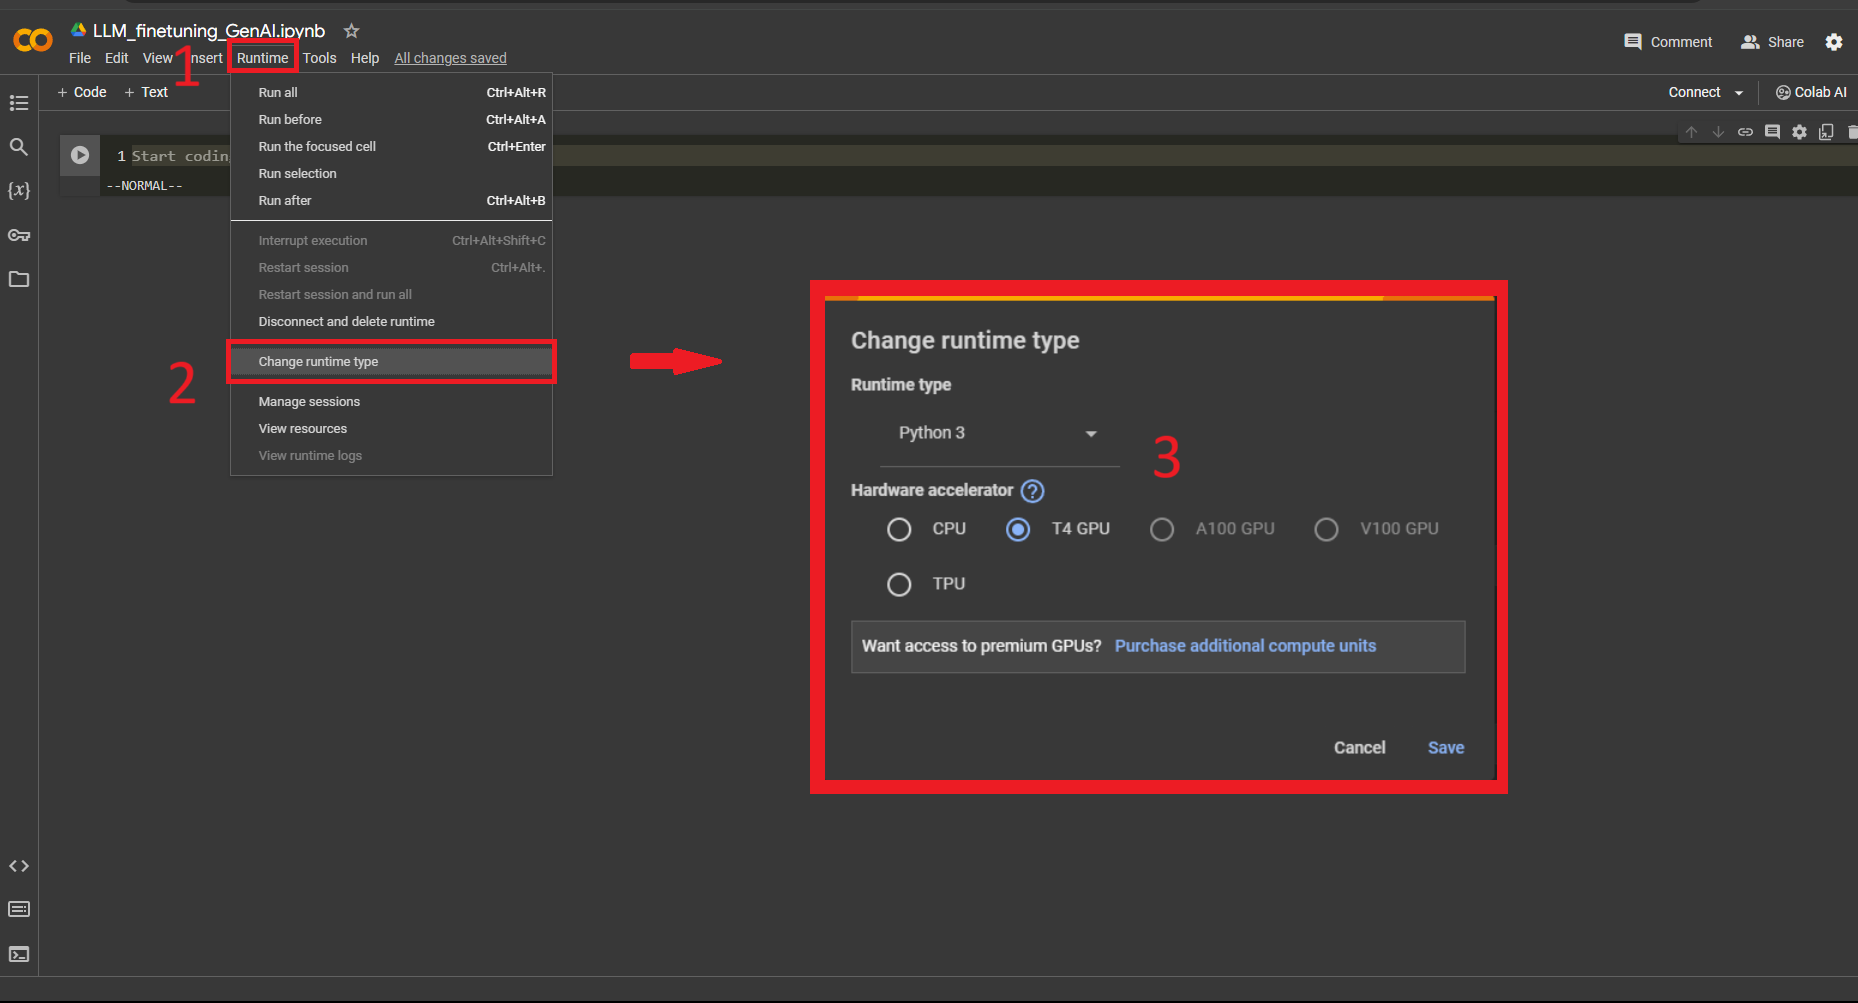

## Install Packages
We install and import some well-written packages created by others to facilitate the fine-tuning process.

The following code block takes about **5** minutes to run, but it may vary depending on the condition of Colab.

In [1]:
""" It is recommmended NOT to change codes in this cell """

!pip install bitsandbytes==0.43.0
!pip install datasets==2.10.1
!pip install transformers==4.38.2
!pip install peft==0.9.0
!pip install sentencepiece==0.1.99
!pip install -U accelerate==0.28.0
!pip install colorama==0.4.6
!pip install fsspec==2023.9.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 9.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 70.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    

The following code block takes about **20** seconds to run, but it may vary depending on the condition of Colab.

In [2]:
""" It is recommmended NOT to change codes in this cell """

import os
import sys
import argparse
import json
import warnings
import logging
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import bitsandbytes as bnb
from datasets import load_dataset, load_from_disk
import transformers, datasets
from peft import PeftModel
from colorama import *

from tqdm import tqdm
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, BitsAndBytesConfig
from transformers import GenerationConfig
from peft import (
    prepare_model_for_int8_training,
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_kbit_training
)

## Download Dataset for Fine-tuning

In [3]:
""" It is recommmended NOT to change codes in this cell """

# Download Training dataset
# reference:https://github.com/chinese-poetry/chinese-poetry/tree/master/%E5%85%A8%E5%94%90%E8%AF%97?fbclid=IwAR2bM14S42T-VtrvMi3wywCqKfYJraBtMl7QVTo0qyPMjX9jj9Vj3JepFBA
!git clone https://github.com/CheeEn-Yu/GenAI-Hw5.git

Cloning into 'GenAI-Hw5'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 38 (delta 15), reused 26 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (38/38), 3.68 MiB | 7.57 MiB/s, done.
Resolving deltas: 100% (15/15), done.


## Fix Random Seeds
There may be some randomness involved in the fine-tuning process. We fix random seeds to make the result reproducible.

In [4]:
""" It is recommmended NOT to change codes in this cell """

seed = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

## Define Some Useful Functions

In [5]:
""" It is recommmended NOT to change codes in this cell """

# 生成訓練資料
def generate_training_data(data_point):
    """
    (1) Goal:
        - This function is used to transform a data point (input and output texts) to tokens that our model can read

    (2) Arguments:
        - data_point: dict, with field "instruction", "input", and "output" which are all str

    (3) Returns:
        - a dict with model's input tokens, attention mask that make our model causal, and corresponding output targets

    (3) Example:
        - If you construct a dict, data_point_1, with field "instruction", "input", and "output" which are all str, you can use the function like this:
            formulate_article(data_point_1)

    """
    # construct full input prompt
    prompt = f"""\
[INST] <<SYS>>
You are a helpful assistant and good at writing Tang poem. 你是一個樂於助人的助手且擅長寫唐詩。
<</SYS>>

{data_point["instruction"]}
{data_point["input"]}
[/INST]"""
    # count the number of input tokens
    len_user_prompt_tokens = (
        len(
            tokenizer(
                prompt,
                truncation=True,
                max_length=CUTOFF_LEN + 1,
                padding="max_length",
            )["input_ids"]
        ) - 1
    )
    # transform input prompt into tokens
    full_tokens = tokenizer(
        prompt + " " + data_point["output"] + "</s>",
        truncation=True,
        max_length=CUTOFF_LEN + 1,
        padding="max_length",
    )["input_ids"][:-1]
    return {
        "input_ids": full_tokens,
        "labels": [-100] * len_user_prompt_tokens
        + full_tokens[len_user_prompt_tokens:],
        "attention_mask": [1] * (len(full_tokens)),
    }

# 進行生成回覆的評估
def evaluate(instruction, generation_config, max_len, input="", verbose=True):
    """
    (1) Goal:
        - This function is used to get the model's output given input strings

    (2) Arguments:
        - instruction: str, description of what you want model to do
        - generation_config: transformers.GenerationConfig object, to specify decoding parameters relating to model inference
        - max_len: int, max length of model's output
        - input: str, input string the model needs to solve the instruction, default is "" (no input)
        - verbose: bool, whether to print the mode's output, default is True

    (3) Returns:
        - output: str, the mode's response according to the instruction and the input

    (3) Example:
        - If you the instruction is "ABC" and the input is "DEF" and you want model to give an answer under 128 tokens, you can use the function like this:
            evaluate(instruction="ABC", generation_config=generation_config, max_len=128, input="DEF")

    """
    # construct full input prompt
    prompt = f"""\
[INST] <<SYS>>
You are a helpful assistant and good at writing Tang poem. 你是一個樂於助人的助手且擅長寫唐詩。
<</SYS>>

{instruction}
{input}
[/INST]"""
    # 將提示文本轉換為模型所需的數字表示形式
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].cuda()
    # 使用模型進行生成回覆
    generation_output = model.generate(
        input_ids=input_ids,
        generation_config=generation_config,
        return_dict_in_generate=True,
        output_scores=True,
        max_new_tokens=max_len,
    )
    # 將生成的回覆解碼並印出
    for s in generation_output.sequences:
        output = tokenizer.decode(s)
        output = output.split("[/INST]")[1].replace("</s>", "").replace("<s>", "").replace("Assistant:", "").replace("Assistant", "").strip()
        if (verbose):
            print(output)

    return output


## Download model and inference before fine-tuning

The following code block takes about **10** minutes to run if you use the default setting, but it may vary depending on the condition of Colab.

In [6]:
""" You may want (but not necessarily need) to change the LLM model """

model_name = "MediaTek-Research/Breeze-7B-Instruct-v0_1"

## Inference before Fine-tuning
Let's first see what our model can do without fine-tuning.

The following code block takes about **2** minutes to run if you use the default setting, but it may vary depending on the condition of Colab.

In [7]:
""" It is recommmended NOT to change codes in this cell """

cache_dir = "./cache"

nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16
)

# 從指定的模型名稱或路徑載入預訓練的語言模型
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    cache_dir=cache_dir,
    quantization_config=nf4_config,
    low_cpu_mem_usage = True
)

# 創建 tokenizer 並設定結束符號 (eos_token)
logging.getLogger('transformers').setLevel(logging.ERROR)
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    add_eos_token=True,
    cache_dir=cache_dir,
    quantization_config=nf4_config
)
tokenizer.pad_token = tokenizer.eos_token

# 設定模型推理時需要用到的decoding parameters
max_len = 128
generation_config = GenerationConfig(
    do_sample=True,
    temperature=0.1,
    num_beams=1,
    top_p=0.3,
    no_repeat_ngram_size=3,
    pad_token_id=2,
)

config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/911k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.79M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

The following code block takes about **1** minutes to run if you use the default setting, but it may vary depending on the condition of Colab.

In [8]:
""" It is recommmended NOT to change codes in this cell """

# demo examples
test_tang_list = ['相見時難別亦難，東風無力百花殘。', '重帷深下莫愁堂，臥後清宵細細長。', '芳辰追逸趣，禁苑信多奇。']

# get the model output for each examples
demo_before_finetune = []
for tang in test_tang_list:
  demo_before_finetune.append(f'模型輸入:\n以下是一首唐詩的第一句話，請用你的知識判斷並完成整首詩。{tang}\n\n模型輸出:\n'+evaluate('以下是一首唐詩的第一句話，請用你的知識判斷並完成整首詩。', generation_config, max_len, tang, verbose = False))

# print and store the output to text file
for idx in range(len(demo_before_finetune)):
  print(f"Example {idx + 1}:")
  print(demo_before_finetune[idx])
  print("-" * 80)


Example 1:
模型輸入:
以下是一首唐詩的第一句話，請用你的知識判斷並完成整首詩。相見時難別亦難，東風無力百花殘。

模型輸出:
相望時難分亦難別，東風吹拂百花欲殘殘。
--------------------------------------------------------------------------------
Example 2:
模型輸入:
以下是一首唐詩的第一句話，請用你的知識判斷並完成整首詩。重帷深下莫愁堂，臥後清宵細細長。

模型輸出:
重帷下，重帷之下，深下，莫愁之堂。
--------------------------------------------------------------------------------
Example 3:
模型輸入:
以下是一首唐詩的第一句話，請用你的知識判斷並完成整首詩。芳辰追逸趣，禁苑信多奇。

模型輸出:
芳辰逐逸趣、禁苑寄多奇，春色似水月，花影如風姿。
--------------------------------------------------------------------------------


## Set Hyperarameters for Fine-tuning



In [9]:
""" It is highly recommended you try to play around this hyperparameter """

num_train_data = 1040 # 設定用來訓練的資料數量，可設置的最大值為5000。在大部分情況下會希望訓練資料盡量越多越好，這會讓模型看過更多樣化的詩句，進而提升生成品質，但是也會增加訓練的時間
                      # 使用預設參數(1040): fine-tuning大約需要25分鐘，完整跑完所有cell大約需要50分鐘
                      # 使用最大值(5000): fine-tuning大約需要100分鐘，完整跑完所有cell大約需要120分鐘

In [10]:
""" You may want (but not necessarily need) to change some of these hyperparameters """

output_dir = "/content"  # 設定作業結果輸出目錄 (如果想要把作業結果存在其他目錄底下可以修改這裡)
ckpt_dir = "./exp1" # 設定model checkpoint儲存目錄 (如果想要將model checkpoints存在其他目錄下可以修改這裡)
num_epoch = 1  # 設定訓練的總Epoch數 (數字越高，訓練越久，若使用免費版的colab需要注意訓練太久可能會斷線)
LEARNING_RATE = 3e-4  # 設定學習率

In [11]:
""" It is recommmended NOT to change codes in this cell """

cache_dir = "./cache"  # 設定快取目錄路徑
from_ckpt = False  # 是否從checkpoint載入模型的權重，預設為否
ckpt_name = None  # 從特定checkpoint載入權重時使用的檔案名稱，預設為無
dataset_dir = "./GenAI-Hw5/Tang_training_data.json"  # 設定資料集的目錄或檔案路徑
logging_steps = 20  # 定義訓練過程中每隔多少步驟輸出一次訓練誌
save_steps = 65  # 定義訓練過程中每隔多少步驟保存一次模型
save_total_limit = 3  # 控制最多保留幾個模型checkpoint
report_to = None  # 設定上報實驗指標的目標，預設為無
MICRO_BATCH_SIZE = 4  # 定義微批次的大小
BATCH_SIZE = 16  # 定義一個批次的大小
GRADIENT_ACCUMULATION_STEPS = BATCH_SIZE // MICRO_BATCH_SIZE  # 計算每個微批次累積的梯度步數
CUTOFF_LEN = 256  # 設定文本截斷的最大長度
LORA_R = 8  # 設定LORA（Layer-wise Random Attention）的R值
LORA_ALPHA = 16  # 設定LORA的Alpha值
LORA_DROPOUT = 0.05  # 設定LORA的Dropout率
VAL_SET_SIZE = 0  # 設定驗證集的大小，預設為無
TARGET_MODULES = ["q_proj", "up_proj", "o_proj", "k_proj", "down_proj", "gate_proj", "v_proj"] # 設定目標模組，這些模組的權重將被保存為checkpoint
device_map = "auto"  # 設定設備映射，預設為"auto"
world_size = int(os.environ.get("WORLD_SIZE", 1))  # 獲取環境變數"WORLD_SIZE"的值，若未設定則預設為1
ddp = world_size != 1  # 根據world_size判斷是否使用分散式數據處理(DDP)，若world_size為1則不使用DDP
if ddp:
    device_map = {"": int(os.environ.get("LOCAL_RANK") or 0)}
    GRADIENT_ACCUMULATION_STEPS = GRADIENT_ACCUMULATION_STEPS // world_size

## Start Fine-tuning

The following code block takes about **25** minutes to run if you use the default setting, but it may vary depending on the condition of Colab.

In [12]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [13]:
""" It is recommmended NOT to change codes in this cell """

# create the output directory you specify
os.makedirs(output_dir, exist_ok = True)
os.makedirs(ckpt_dir, exist_ok = True)

# 根據 from_ckpt 標誌，從 checkpoint 載入模型權重
if from_ckpt:
    model = PeftModel.from_pretrained(model, ckpt_name)

# 將模型準備好以使用 INT8 訓練
model = prepare_model_for_int8_training(model)

# 使用 LoraConfig 配置 LORA 模型
config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=TARGET_MODULES,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, config)

# 將 tokenizer 的 padding token 設定為 0
tokenizer.pad_token_id = 0

# 載入並處理訓練數據
with open(dataset_dir, "r", encoding = "utf-8") as f:
    data_json = json.load(f)
with open("tmp_dataset.json", "w", encoding = "utf-8") as f:
    json.dump(data_json[:num_train_data], f, indent = 2, ensure_ascii = False)

data = load_dataset('json', data_files="tmp_dataset.json", download_mode="force_redownload")

# 將訓練數據分為訓練集和驗證集（若 VAL_SET_SIZE 大於 0）
if VAL_SET_SIZE > 0:
    train_val = data["train"].train_test_split(
        test_size=VAL_SET_SIZE, shuffle=True, seed=42
    )
    train_data = train_val["train"].shuffle().map(generate_training_data)
    val_data = train_val["test"].shuffle().map(generate_training_data)
else:
    train_data = data['train'].shuffle().map(generate_training_data)
    val_data = None

# 使用 Transformers Trainer 進行模型訓練
trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=MICRO_BATCH_SIZE,
        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
        warmup_steps=50,
        num_train_epochs=num_epoch,
        learning_rate=LEARNING_RATE,
        fp16=True,  # 使用混合精度訓練
        logging_steps=logging_steps,
        save_strategy="steps",
        save_steps=save_steps,
        output_dir=ckpt_dir,
        save_total_limit=save_total_limit,
        ddp_find_unused_parameters=False if ddp else None,  # 是否使用 DDP，控制梯度更新策略
        report_to=report_to,
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

# 禁用模型的 cache 功能
model.config.use_cache = False

# 若使用 PyTorch 2.0 版本以上且非 Windows 系統，進行模型編譯
if torch.__version__ >= "2" and sys.platform != 'win32':
    model = torch.compile(model)

# 開始模型訓練
trainer.train()

# 將訓練完的模型保存到指定的目錄中
model.save_pretrained(ckpt_dir)

# 印出訓練過程中可能的缺失權重的警告信息
print("\n If there's a warning about missing keys above, please disregard :)")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-04410f97106327cc/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1040 [00:00<?, ? examples/s]

{'loss': 3.3131, 'grad_norm': 1.9737329483032227, 'learning_rate': 0.00011999999999999999, 'epoch': 0.31}
{'loss': 2.0187, 'grad_norm': 1.984153389930725, 'learning_rate': 0.00023999999999999998, 'epoch': 0.62}
{'loss': 1.9825, 'grad_norm': 1.208337664604187, 'learning_rate': 9.999999999999999e-05, 'epoch': 0.92}


config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

{'train_runtime': 1149.1506, 'train_samples_per_second': 0.905, 'train_steps_per_second': 0.057, 'train_loss': 2.4048057115994967, 'epoch': 1.0}

 If there's a warning about missing keys above, please disregard :)


##  Testing
The fine-tuning process is done. We then want to test whether our model can do the task that we wanted it to do before but failed.

We need to first load the fine-tuned model for checkpoint we saved.

In [14]:
""" It is recommmended NOT to change codes in this cell """

# find all available checkpoints
ckpts = []
for ckpt in os.listdir(ckpt_dir):
    if (ckpt.startswith("checkpoint-")):
        ckpts.append(ckpt)

# list all the checkpoints
ckpts = sorted(ckpts, key = lambda ckpt: int(ckpt.split("-")[-1]))
print("all available checkpoints:")
print(" id: checkpoint name")
for (i, ckpt) in enumerate(ckpts):
    print(f"{i:>3}: {ckpt}")


all available checkpoints:
 id: checkpoint name
  0: checkpoint-65


In [15]:
""" You may want (but not necessarily need) to change the check point """

id_of_ckpt_to_use = -1  # 要用來進行推理的checkpoint的id(對應上一個cell的輸出結果)
                        # 預設值-1指的是上列checkpoints中的"倒數"第一個，也就是最後一個checkpoint
                        # 如果想要選擇其他checkpoint，可以把-1改成有列出的checkpoint id中的其中一個

ckpt_name = os.path.join(ckpt_dir, ckpts[id_of_ckpt_to_use])

In [16]:
""" You may want (but not necessarily need) to change decoding parameters """
# 你可以在這裡調整decoding parameter，decoding parameter的詳細解釋請見homework slides
max_len = 128   # 生成回復的最大長度
temperature = 0.1  # 設定生成回覆的隨機度，值越小生成的回覆越穩定
top_p = 0.3  # Top-p (nucleus) 抽樣的機率閾值，用於控制生成回覆的多樣性
# top_k = 5 # 調整Top-k值，以增加生成回覆的多樣性和避免生成重複的詞彙

The following code block takes about **2** minutes to run if you use the default setting, but it may vary depending on the condition of Colab.

In [17]:
""" It is recommmended NOT to change codes in this cell """

test_data_path = "GenAI-Hw5/Tang_testing_data.json"
output_path = os.path.join(output_dir, "results.txt")

cache_dir = "./cache"  # 設定快取目錄路徑
seed = 42  # 設定隨機種子，用於重現結果
no_repeat_ngram_size = 3  # 設定禁止重複 Ngram 的大小，用於避免生成重複片段

nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16
)

# 使用 tokenizer 將模型名稱轉換成模型可讀的數字表示形式
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    cache_dir=cache_dir,
    quantization_config=nf4_config
)

# 從預訓練模型載入模型並設定為 8 位整數 (INT8) 模型
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=nf4_config,
    device_map={'': 0},  # 設定使用的設備，此處指定為 GPU 0
    cache_dir=cache_dir
)

# 從指定的 checkpoint 載入模型權重
model = PeftModel.from_pretrained(model, ckpt_name, device_map={'': 0})

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The following code block takes about **4** minutes to run if you use the default setting, but it may vary depending on the condition of Colab.

In [18]:
""" It is recommmended NOT to change codes in this cell """

results = []

# 設定生成配置，包括隨機度、束搜索等相關參數
generation_config = GenerationConfig(
    do_sample=True,
    temperature=temperature,
    num_beams=1,
    top_p=top_p,
    # top_k=top_k,
    no_repeat_ngram_size=no_repeat_ngram_size,
    pad_token_id=2
)

# 讀取測試資料
with open(test_data_path, "r", encoding = "utf-8") as f:
    test_datas = json.load(f)

# 對於每個測試資料進行預測，並存下結果
with open(output_path, "w", encoding = "utf-8") as f:
  for (i, test_data) in enumerate(test_datas):
      predict = evaluate(test_data["instruction"], generation_config, max_len, test_data["input"], verbose = False)
      f.write(f"{i+1}. "+test_data["input"]+predict+"\n")
      print(f"{i+1}. "+test_data["input"]+predict)


1. 雪霽銀妝素，桔高映瓊枝。玉露含花影，金風吹葉聲。
2. 夫子何爲者？栖栖一代中。不爮不羣，不竈不室。不疎不皐，不飜不髙。不顦不馔，不啓不閉。
</SYS>
3. 飛蓋去芳園，蘭橈遊翠渚。春色不相待，花影已相隨。
4. 條風開獻節，灰律動初陽。玉露含芳草，金花映春山。
5. 昨夜星辰昨夜風，畫樓西畔桂堂東。月明人未歸，花落鳥未鳴。
6. 三日入廚下，洗手作羹湯。不似前年時，君恩已不似。
7. 嵩雲秦樹久離居，雙鯉迢迢一紙書。君恩如海無歸日，何須寄書寄不歸。
8. 慨然撫長劒，濟世豈邀名。君恩不相忘，君恩豈相忘。
9. 乘興南遊不戒嚴，九重誰省諫書函。君恩如海無波息，何須朝朝上書問。
10. 猿鳥猶疑畏簡書，風雲常爲護儲胥。君恩如日無時滅，臣忠如水無時流。
11. 君問歸期未有期，巴山夜雨漲秋池。月明空山獨不眠，風起秋草不相知。
12. 相見時難別亦難，東風無力百花殘。春光已過花已落，誰言君恩如故。
13. 雲母屏風燭影深，長河漸落曉星沈。月出水邊照波光，風起沙洲吹沙聲。
14. 高閣客竟去，小園花亂飛。春光不相待，春色更相爲。
15. 瑤池阿母綺窗開，黃竹歌聲動地哀。玉葉含露垂垂葉，金枝含露含露花。


## See how the fine-tune model do compared to model without fine-tuning

We now check what our model can do on the same examples we saw in the "Inference before Fine-tuning" section above.

The following code block takes about **40** seconds to run if you use the default setting, but it may vary depending on the condition of Colab.

In [19]:
# using the same demo examples as before
test_tang_list = ['相見時難別亦難，東風無力百花殘。', '重帷深下莫愁堂，臥後清宵細細長。', '芳辰追逸趣，禁苑信多奇。']

# inference our fine-tuned model
demo_after_finetune = []
for tang in test_tang_list:
  demo_after_finetune.append(f'模型輸入:\n以下是一首唐詩的第一句話，請用你的知識判斷並完成整首詩。{tang}\n\n模型輸出:\n'+evaluate('以下是一首唐詩的第一句話，請用你的知識判斷並完成整首詩。', generation_config, max_len, tang, verbose = False))

# print and store the output to text file
for idx in range(len(demo_after_finetune)):
  print(f"Example {idx + 1}:")
  print(demo_after_finetune[idx])
  print("-" * 80)


Example 1:
模型輸入:
以下是一首唐詩的第一句話，請用你的知識判斷並完成整首詩。相見時難別亦難，東風無力百花殘。

模型輸出:
春光已過花已落，誰言君恩如故。
--------------------------------------------------------------------------------
Example 2:
模型輸入:
以下是一首唐詩的第一句話，請用你的知識判斷並完成整首詩。重帷深下莫愁堂，臥後清宵細細長。

模型輸出:
月明人未歸，風起花未香。
--------------------------------------------------------------------------------
Example 3:
模型輸入:
以下是一首唐詩的第一句話，請用你的知識判斷並完成整首詩。芳辰追逸趣，禁苑信多奇。

模型輸出:
花間舞龍影，水邊唱鳳聲。玉葉垂翠樹，金波映碧波。何須遠尋處，此中盡可居。
--------------------------------------------------------------------------------
